In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import matplotlib.pyplot as plt
import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()
sc = SparkContext.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

23/12/17 18:27:59 WARN Utils: Your hostname, MacBook-Pro-di-Francesco-4.local resolves to a loopback address: 127.0.0.1; using 192.168.1.136 instead (on interface en0)
23/12/17 18:27:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/17 18:28:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read File
Arguments:
filename – name of the spam dataset file \
12 columns: 11 features/dimensions (X) + 1 column with labels (Y) \
 Y - Train labels (0 if normal traffic, 1 if botnet)
 m rows: number of examples (m)

Returns:
An RDD containing the data of filename. \
Each example (row) of the filecorresponds to one RDD record. \
Each record of the RDD is a tuple (X,y). \
“X” is an array containing the 11 features (float number) of an example “y” is the 12th column of an example (integer 0/1) 

In [2]:
def readFile(filename):

    # Read the file into an RDD
    lines = sc.textFile(filename)

    # Process each line in the RDD, each element in data ends in a tuple containing a list of the first 11 features, and a number representing the target
    data = lines.map(lambda line: line.split(','))\
                .map(lambda elem: ([float(x) for x in elem[:-1]], int(elem[-1])))

    return data

## Normalization
Arguments:
RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple (X,y). \
 “X” is an array containing the 11 features (float number) of an example “y” is the label of the example (integer 0/1) \
 
Returns:
An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1)

In [3]:
def compute_mean_stds(RDD):

    # Calculate sum and sum of squares for each feature
    sums = RDD.map(lambda x: x[0]).reduce(lambda a, b: a+b)
    sum_of_squares = RDD.map(lambda x: x[0]**2).reduce(lambda a, b: a+b)
    count = RDD.count()

    # Compute mean and standard deviation for each feature
    means = sums / count
    stds = ((sum_of_squares / count) - means ** 2) ** 0.5 
    
    return means, stds


def normalize(RDD_Xy):
    # Compute means and standard deviations
    means, stds = compute_mean_stds(RDD_Xy)

    normalized_RDD = RDD_Xy.map(lambda x: ((x[0] - means) / stds , x[1]))
    return normalized_RDD



## Train 
Arguments:
RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple (X,y). \
 “X” is an array containing the 11 features (float number) of an example “y” is the label of the example (integer 0/1) \
 iterations -- number of iterations of the optimization loop \
 learning_rate -- learning rate of the gradient descent \
 lambda_reg – regularization rate \

Returns:
A list or array containing the weights “w” and bias “b” at the end of the training process

In [4]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Function that computes the value z, which is a linear combination of weights and features + the bias
def linear_combination(features, weights, bias):
    return sum(weights[j] * features[j] for j in range(len(weights))) + bias


# Function to compute the gradient of each record (row) of the dataset
def compute_gradients_and_cost(record, weights, bias):
    xi, yi = record

    y_hat = sigmoid(linear_combination(xi, weights, bias))
    error = y_hat - yi
    dw = np.zeros(len(weights))

    for j in range(len(weights)):
        dw[j] = error * xi[j]
    
    db = error
    cost_contribution = -yi * np.log(y_hat) - (1 - yi) * np.log(1 - y_hat)
    
    return (dw, db, cost_contribution)


# Actual train function
def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    np.random.seed(0) 
    feature_count = len(RDD_Xy.first()[0])
    w = np.random.rand(feature_count)
    b = np.random.rand()
    m = RDD_Xy.count()

    for n in range(iterations):
        
        gradients_and_cost = RDD_Xy.map(lambda x: compute_gradients_and_cost(x, w, b))
        dw, db, total_cost = gradients_and_cost.reduce(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2]))
        
        reg_cost = (lambda_reg / (2 * feature_count)) * np.sum(np.square(w))
        cost = (total_cost / m) + reg_cost
        
        # Update weights and bias
        w -= learning_rate * ((dw / m) + (lambda_reg/m) * w)
        b -= learning_rate * db / m


        print(f"Iteration {n+1}/{iterations} - Cost: {cost}")

    return w, b


## Predict
Arguments: \
 w -- weights  \
 b -- bias \
 X – Example to be predicted 

 Returns:
 Y_pred – a value (0/1) corresponding to the prediction of X

In [5]:
def predict(w, b, x, threshold=0.5):
    z = 0
    for j in range(len(w)):
        z += w[j] * x[j]

    z+= b
    # Compute the sigmoid of z
    y_hat = sigmoid(z)

    if y_hat > threshold:
        return 1
    else: 
        return 0


## Accuracy
 Arguments: \
 w -- weights \
 b -- bias \
 RDD_Xy – RDD containing examples to be predicted 

 Returns: \
accuracy -- the number of predictions that are correct divided by the number of records (examples) in RDD_xy. \
Predict function can be used for predicting a single example 

In [6]:
def accuracy(w, b, RDD_Xy):
    
    results = RDD_Xy.map(lambda r: 1 if predict(w, b, r[0]) == r[1] else 0)
    results = results.reduce( lambda a, b: a + b)

    accuracy = results / RDD_Xy.count()
    return accuracy


In [7]:
def compute_metrics(RDD_Xy, w, b):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    def calculate_metrics_for_threshold(RDD, threshold):
        # Calculate TP, FP, TN, FN for a given threshold
        metrics = RDD.map(lambda x: (predict(w, b, x[0], threshold), x[1])) \
                     .map(lambda x: (int(x[0] == 1 and x[1] == 1), int(x[0] == 1 and x[1] == 0), int(x[0] == 0 and x[1] == 0), int(x[0] == 0 and x[1] == 1))) \
                     .reduce(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2], a[3] + b[3]))
        TP, FP, TN, FN = metrics

        return TP, FP, TN, FN

    # Compute metrics for each threshold
    metrics_for_thresholds = {thresh: calculate_metrics_for_threshold(RDD_Xy, thresh) for thresh in thresholds}
    return metrics_for_thresholds

## Main
Here we can change the number of workers and we save the execution time.

In [8]:
import os
import sys
import time

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
import pyspark
sc.stop()
times = []
for i in range(1, 13):
    print("Number of cores: ", i)
    start_time = time.time()
    number_cores = i
    conf = (
        pyspark.SparkConf()
            .setMaster('local[{}]'.format(number_cores))
    )
    sc = pyspark.SparkContext(conf=conf)

    filename = 'data/botnet_tot_syn_l.csv'
    RDD_Xy = readFile(filename).map( lambda x: (np.array(x[0]), x[1]))
    normalized_RDD = normalize(RDD_Xy)
    w, b = train(normalized_RDD, 10, 1.5, 0)
    acc = accuracy(w, b, normalized_RDD)
    print("Accuracy: ", acc)
    times.append(time.time() - start_time)
    if i == 12:
        metrics_for_thresholds = compute_metrics(normalized_RDD, w, b)

    sc.stop()

Number of cores:  1


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  2


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  3


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  4


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  5


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  6


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  7


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  8


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  9


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  10


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  11


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181
Number of cores:  12


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


Accuracy:  0.930181


## Metrics

accuracy: [0.777585 0.858916 0.897581 0.919363 0.930181 0.931607 0.918127 0.8758
 0.774564]
precision: [0.6927928  0.78373883 0.84052355 0.8827555  0.91533445 0.94195312
 0.96296928 0.98013533 0.99250915]
recall: [0.99749  0.991392 0.98136  0.967184 0.948054 0.919902 0.869698 0.767148
 0.553304]
F1: [0.81767843 0.87541988 0.90549826 0.92304315 0.93140696 0.93079698
 0.91396018 0.86066048 0.71051185]


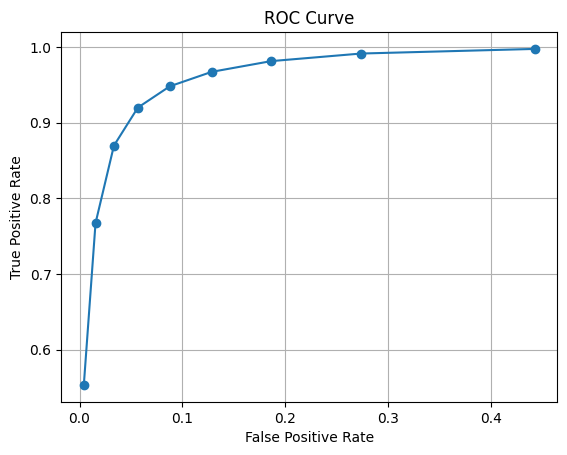

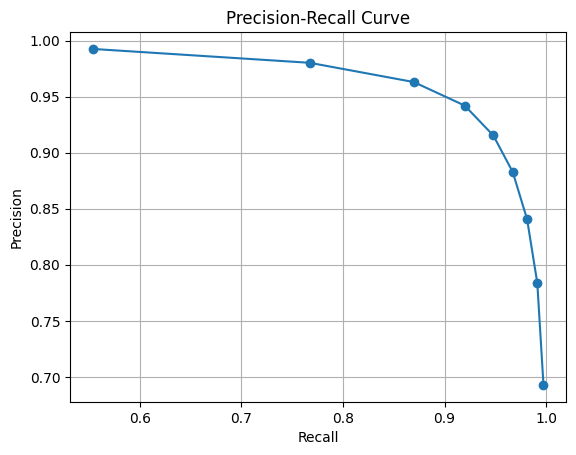

threshold: 0.1
TP: 498745
FP: 221160
TN: 278840
FN: 1255
accuracy: 0.777585
precision: 0.6927927990498747
recall: 0.99749
F1: 0.8176784257790566

threshold: 0.2
TP: 495696
FP: 136780
TN: 363220
FN: 4304
accuracy: 0.858916
precision: 0.7837388296156692
recall: 0.991392
F1: 0.8754198764477128

threshold: 0.3
TP: 490680
FP: 93099
TN: 406901
FN: 9320
accuracy: 0.897581
precision: 0.8405235542902365
recall: 0.98136
F1: 0.9054982611768635

threshold: 0.4
TP: 483592
FP: 64229
TN: 435771
FN: 16408
accuracy: 0.919363
precision: 0.8827554986026458
recall: 0.967184
F1: 0.9230431533630268

threshold: 0.5
TP: 474027
FP: 43846
TN: 456154
FN: 25973
accuracy: 0.930181
precision: 0.9153344545863561
recall: 0.948054
F1: 0.93140696334415

threshold: 0.6
TP: 459951
FP: 28344
TN: 471656
FN: 40049
accuracy: 0.931607
precision: 0.9419531226000676
recall: 0.919902
F1: 0.9307969786349217

threshold: 0.7
TP: 434849
FP: 16722
TN: 483278
FN: 65151
accuracy: 0.918127
precision: 0.9629692783637568
recall: 0.869698


In [11]:
TP = []
FP = []
TN = []
FN = []

for threshold, metrics in metrics_for_thresholds.items():
    TP.append(metrics[0])
    FP.append(metrics[1])
    TN.append(metrics[2])
    FN.append(metrics[3])

TP = np.array(TP)
FP = np.array(FP)
TN = np.array(TN)
FN = np.array(FN)
#Accuracy
accuracy = (TP + TN) / (TP + FP + TN + FN)
print("accuracy:", accuracy)
#Precision
precision = TP / (TP + FP)
print("precision:", precision)
#Recall
recall = TP / (TP + FN)
print("recall:", recall)
#F1
F1 = 2 * precision * recall / (precision + recall)
print("F1:", F1)
#ROC
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
plt.plot(FPR, TPR, marker='o')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()
#Precision-Recall
plt.plot(recall, precision, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()
#plot confusion matrix
for i in range(9):
    print("threshold:", (i+1)/10)
    print("TP:", TP[i])
    print("FP:", FP[i])
    print("TN:", TN[i])
    print("FN:", FN[i])
    print("accuracy:", accuracy[i])
    print("precision:", precision[i])
    print("recall:", recall[i])
    print("F1:", F1[i])
    print("")

## Performances with Different Workers

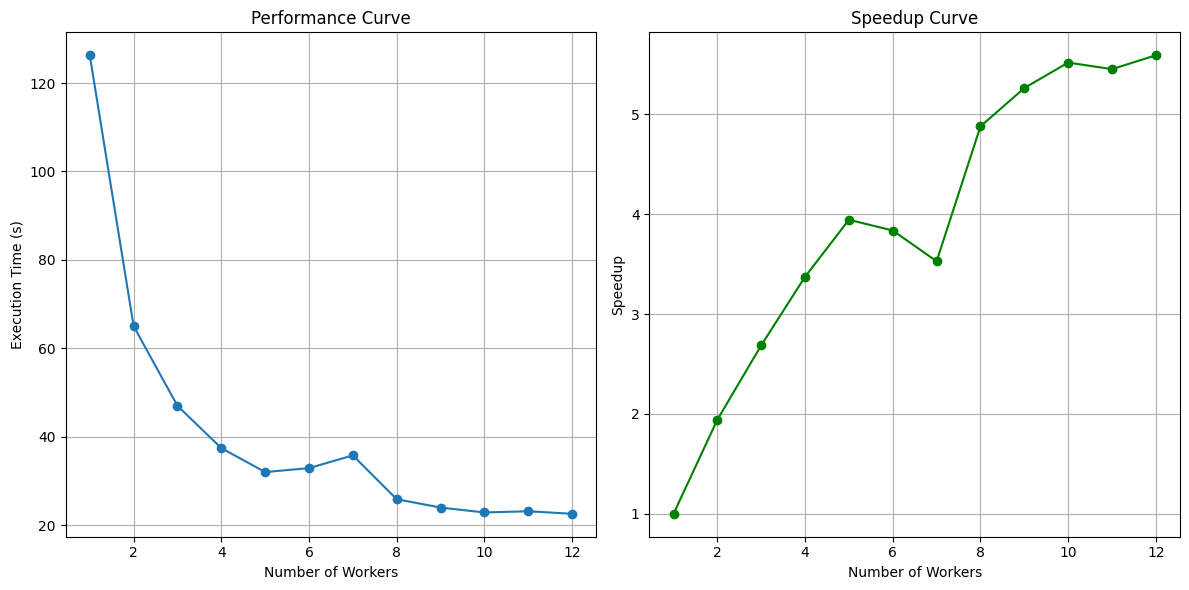

In [12]:
import matplotlib.pyplot as plt

# Replace this with your actual execution times

number_of_workers = list(range(1,13))  # Number of workers from 1 to 9

# Calculating speedup
base_time = times[0]  # Time taken for execution with 1 worker
speedup = [base_time / t for t in times]

# Plotting performance curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(number_of_workers, times, marker='o')
plt.title('Performance Curve')
plt.xlabel('Number of Workers')
plt.ylabel('Execution Time (s)')
plt.grid(True)

# Plotting speedup curve
plt.subplot(1, 2, 2)
plt.plot(number_of_workers, speedup, marker='o', color='green')
plt.title('Speedup Curve')
plt.xlabel('Number of Workers')
plt.ylabel('Speedup')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()
